In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go

In [2]:
train = pd.read_csv('datasets/train.csv')
train['set'] = 'train'
test = pd.read_csv('datasets/test.csv')
test['Survived'] = 0
test['set'] = 'test'

In [3]:
len(test)

418

In [4]:
train = train[['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp','Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'set']]
test = test[['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp','Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'set']]

df = train.append(test)
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked    set  
0      0         A/5 21171   7.2500   NaN        S  train  
1      0          PC 17599  71.2833   C85        C  train  
2      0  STON/O2. 3101282   7.9250   NaN        S  train  
3      0            113803  53.1000  C123        S  train  
4      0            373450   8.0500   NaN        S  train

# Feature Engineering

In [5]:
df["Name"] = df["Name"].str.replace(r"\"", "")

In [6]:
cabin_dummies = df['Cabin'].str.extract(r'(?P<cabin_prefx>[a-zA-Z]*?)(?P<cabin_sufx>[0-9]+)$')
name_dummies = df['Name'].str.extract(r'^(?P<Family_Name>[a-zA-Z]+)\s*,\s*(?P<pronoun>[a-zA-Z]+)\s*\.\s*(?P<First_Name>[\s*\w()]*)')
df["prefix_ticket"] = df["Ticket"].str.extract(r"^([A-Za-z.-\/ ]+) ?")
df["prefix_ticket"] = df["prefix_ticket"].str.replace("[\/., ]", "")
df["prefix_ticket"] = df["prefix_ticket"].str.upper()

df = pd.concat([df,cabin_dummies], axis=1)
df = pd.concat([df,name_dummies], axis=1)

In [7]:
len(df[df["set"]=='test'])

418

In [8]:
family_size = pd.DataFrame(df['Family_Name'].value_counts()).reset_index()
family_size.columns = ["Family_Name", "Family_Size"]
df = df.merge(family_size, how="left", left_on='Family_Name', right_on='Family_Name')

In [9]:
len(df[df["set"]=='test'])

418

# data prep

## missing values

In [10]:
df = df.fillna(0)

## creating dummies

In [11]:
from sklearn import preprocessing
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [12]:
dummizar = ['Pclass','Sex','Parch','pronoun','cabin_prefx', 'Family_Name', 'prefix_ticket']

df_antigo = df

for i in dummizar:
    df = create_dummies(df, i)

In [13]:
df.head()

PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   

    Age  SibSp            Ticket     Fare Cabin Embarked    set  \
0  22.0      1         A/5 21171   7.2500     0        S  train   
1  38.0      1          PC 17599  71.2833   C85        C  train   
2  26.0      0  STON/O2. 3101282   7.9250     0        S  train   
3  35.0      1            113803  53.1000  C123        S  train   
4  35.0      0            373450   8.0500     0        S  train   

         ...         prefix_ticket_SOP prefix_ticket_SOPP  \
0        ...                         0                  0   
1        ...                         0                  0   
2        ...                         0                  0   
3        ...                         0                  0   
4        ...                         0                  0   

   prefix_ticket_SOTONO  prefix_ticket_SOTONOQ  prefix_ticket_SP  \
0                     0                      0                 0   
1                     0                      0                 0   
2                     0                      0                 0   
3                     0                      0                 0   
4                     0                      0                 0   

   prefix_ticket_STONO  prefix_ticket_STONOQ  prefix_ticket_SWPP  \
0                    0                     0                   0   
1                    0                     0                   0   
2                    1                     0                   0   
3                    0                     0                   0   
4                    0                     0                   0   

   prefix_ticket_WC  prefix_ticket_WEP  
0                 0                  0  
1                 0                  0  
2                 0                  0  
3                 0                  0  
4                 0                  0  

[5 rows x 904 columns]

# Separate Train and Test (kaggle dataset)

In [14]:
df_antigo_test = df_antigo[df_antigo["set"] == "test"]
df_antigo = df_antigo[df_antigo["set"] == "train"]

df_test = df[df["set"] == "test"]
df = df[df["set"] == "train"]

## separating numeric values

In [15]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']
df_features = df.select_dtypes(include=numerics)
display(df_features.head())

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']
df_features_test = df_test.select_dtypes(include=numerics)
display(df_features_test.head())

PassengerId  Survived   Age  SibSp     Fare  Family_Size  Pclass_2  \
0            1         0  22.0      1   7.2500          2.0         0   
1            2         1  38.0      1  71.2833          2.0         0   
2            3         1  26.0      0   7.9250          1.0         0   
3            4         1  35.0      1  53.1000          2.0         0   
4            5         0  35.0      0   8.0500          2.0         0   

   Pclass_3  Sex_male  Parch_1        ...          prefix_ticket_SOP  \
0         1         1        0        ...                          0   
1         0         0        0        ...                          0   
2         1         0        0        ...                          0   
3         0         0        0        ...                          0   
4         1         1        0        ...                          0   

   prefix_ticket_SOPP  prefix_ticket_SOTONO  prefix_ticket_SOTONOQ  \
0                   0                     0                      0   
1                   0                     0                      0   
2                   0                     0                      0   
3                   0                     0                      0   
4                   0                     0                      0   

   prefix_ticket_SP  prefix_ticket_STONO  prefix_ticket_STONOQ  \
0                 0                    0                     0   
1                 0                    0                     0   
2                 0                    1                     0   
3                 0                    0                     0   
4                 0                    0                     0   

   prefix_ticket_SWPP  prefix_ticket_WC  prefix_ticket_WEP  
0                   0                 0                  0  
1                   0                 0                  0  
2                   0                 0                  0  
3                   0                 0                  0  
4                   0                 0                  0  

[5 rows x 897 columns]

PassengerId  Survived   Age  SibSp     Fare  Family_Size  Pclass_2  \
891          892         0  34.5      0   7.8292          5.0         0   
892          893         0  47.0      1   7.0000          1.0         0   
893          894         0  62.0      0   9.6875          1.0         1   
894          895         0  27.0      0   8.6625          1.0         0   
895          896         0  22.0      1  12.2875          2.0         0   

     Pclass_3  Sex_male  Parch_1        ...          prefix_ticket_SOP  \
891         1         1        0        ...                          0   
892         1         0        0        ...                          0   
893         0         1        0        ...                          0   
894         1         1        0        ...                          0   
895         1         0        1        ...                          0   

     prefix_ticket_SOPP  prefix_ticket_SOTONO  prefix_ticket_SOTONOQ  \
891                   0                     0                      0   
892                   0                     0                      0   
893                   0                     0                      0   
894                   0                     0                      0   
895                   0                     0                      0   

     prefix_ticket_SP  prefix_ticket_STONO  prefix_ticket_STONOQ  \
891                 0                    0                     0   
892                 0                    0                     0   
893                 0                    0                     0   
894                 0                    0                     0   
895                 0                    0                     0   

     prefix_ticket_SWPP  prefix_ticket_WC  prefix_ticket_WEP  
891                   0                 0                  0  
892                   0                 0                  0  
893                   0                 0                  0  
894                   0                 0                  0  
895                   0                 0                  0  

[5 rows x 897 columns]

### descriptive new features

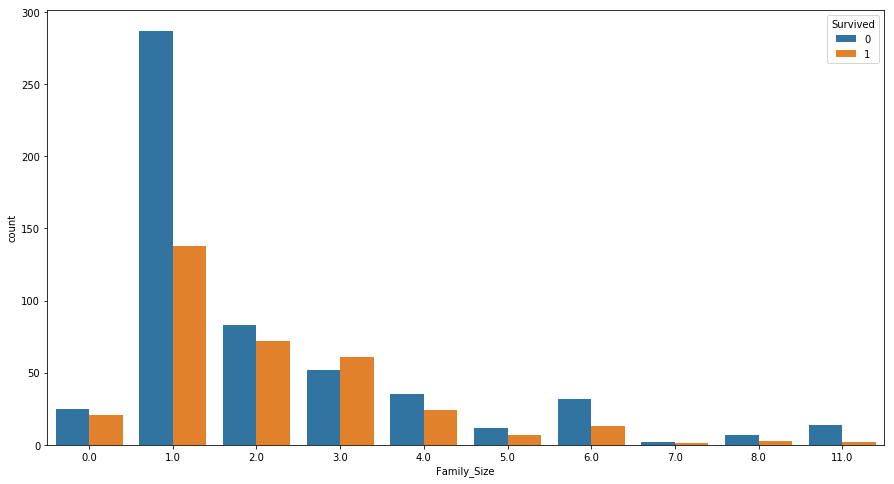

In [16]:
plt.figure(figsize=(15,8))
sns.countplot(df_antigo["Family_Size"], hue=df_antigo["Survived"], orient="h")

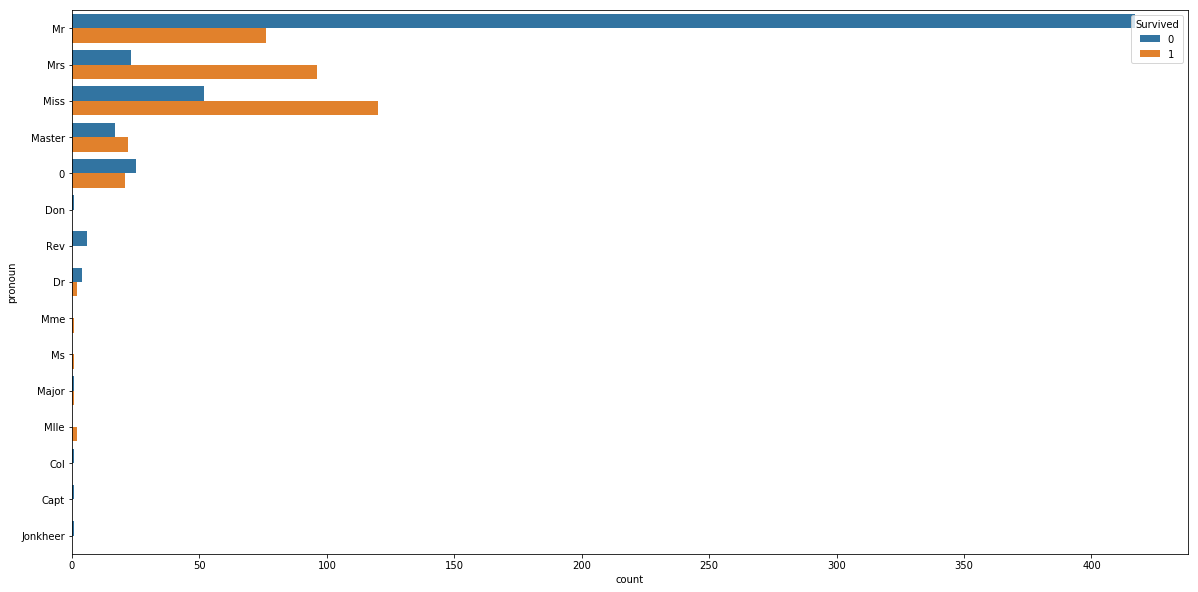

In [17]:
plt.figure(figsize=(20,10))
sns.countplot(y=df_antigo["pronoun"], hue=df_antigo["Survived"], orient="h")

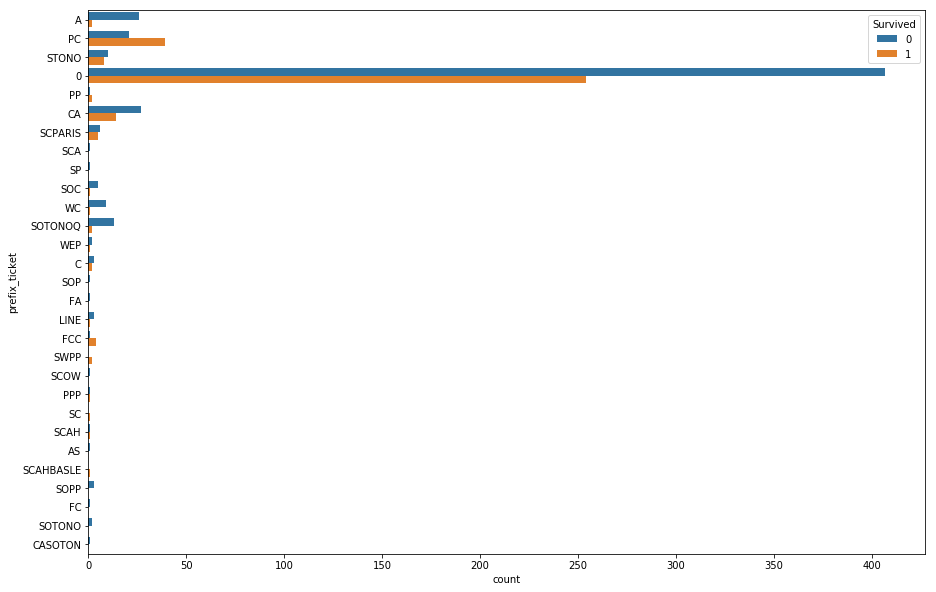

In [18]:
plt.figure(figsize=(15,10))
sns.countplot(y=df_antigo["prefix_ticket"], hue=df_antigo["Survived"], orient="h")

<Figure size 432x288 with 0 Axes>

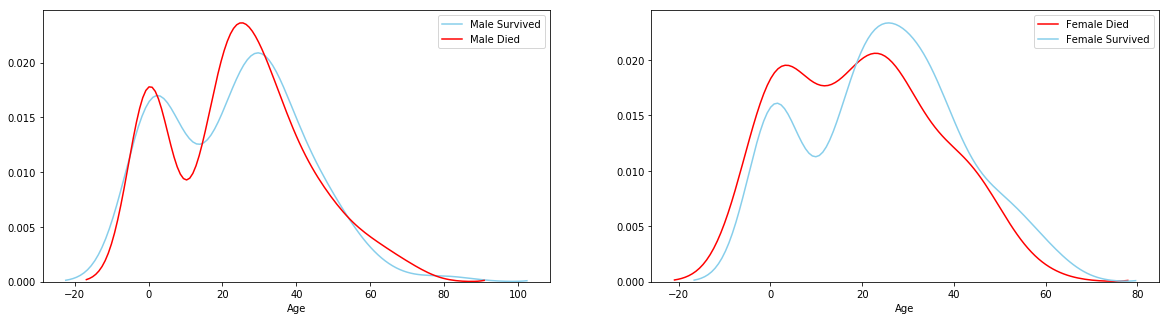

In [19]:
plt.clf()
fig, axes = plt.subplots(1, 2, figsize=(20,5))

df_antigo_male = df_antigo[df_antigo["Sex"] == "male"]
df_antigo_female = df_antigo[df_antigo["Sex"] == "female"]

sns.distplot( df_antigo_male[df_antigo_male["Survived"]==1]["Age"], hist=False, color="skyblue", label="Male Survived", ax=axes[0])
sns.distplot( df_antigo_male[df_antigo_male["Survived"]==0]["Age"], hist=False, color="red", label="Male Died", ax=axes[0])

sns.distplot( df_antigo_female[df_antigo_female["Survived"]==0]["Age"] , hist=False, color="red", label="Female Died", ax=axes[1])
sns.distplot( df_antigo_female[df_antigo_female["Survived"]==1]["Age"] , hist=False, color="skyblue", label="Female Survived", ax=axes[1])

plt.legend()


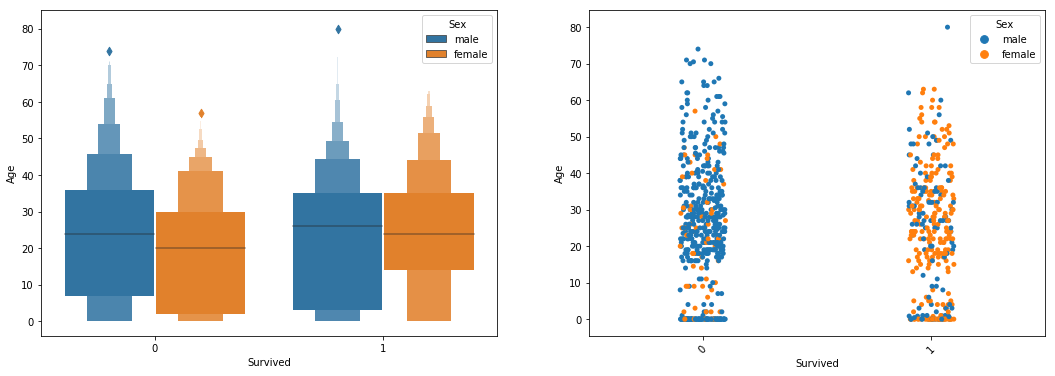

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

boxen = sns.boxenplot(x='Survived', y='Age', hue='Sex', data=df_antigo, ax=axes[0]);
plt.setp(boxen.artists, alpha=.5, linewidth=2, edgecolor="k");

strip = sns.stripplot(x='Survived', y='Age', hue='Sex', data=df_antigo, ax=axes[1]);
plt.setp(strip.artists, alpha=.5, linewidth=2, edgecolor="k");

plt.xticks(rotation=45);

In [21]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'set',
       ...
       'prefix_ticket_SOP', 'prefix_ticket_SOPP', 'prefix_ticket_SOTONO',
       'prefix_ticket_SOTONOQ', 'prefix_ticket_SP', 'prefix_ticket_STONO',
       'prefix_ticket_STONOQ', 'prefix_ticket_SWPP', 'prefix_ticket_WC',
       'prefix_ticket_WEP'],
      dtype='object', length=904)

In [22]:
quantitative_features_list = ["Sex_male","pronoun_Mr","Pclass_3","Fare","pronoun_Mrs","pronoun_Miss","Age","SibSp","Parch_1","cabin_prefx_B","cabin_prefx_D","cabin_prefx_E","Pclass_2","Parch_2","pronoun_Master","cabin_prefx_C","prefix_ticket_A","prefix_ticket_FCC","prefix_ticket_PC"]
df_quantitative_values = df[quantitative_features_list]
df_quantitative_values.head()

Sex_male  pronoun_Mr  Pclass_3     Fare  pronoun_Mrs  pronoun_Miss   Age  \
0         1           1         1   7.2500            0             0  22.0   
1         0           0         0  71.2833            1             0  38.0   
2         0           0         1   7.9250            0             1  26.0   
3         0           0         0  53.1000            1             0  35.0   
4         1           1         1   8.0500            0             0  35.0   

   SibSp  Parch_1  cabin_prefx_B  cabin_prefx_D  cabin_prefx_E  Pclass_2  \
0      1        0              0              0              0         0   
1      1        0              0              0              0         0   
2      0        0              0              0              0         0   
3      1        0              0              0              0         0   
4      0        0              0              0              0         0   

   Parch_2  pronoun_Master  cabin_prefx_C  prefix_ticket_A  prefix_ticket_FCC  \
0        0               0              0                1                  0   
1        0               0              1                0                  0   
2        0               0              0                0                  0   
3        0               0              1                0                  0   
4        0               0              0                0                  0   

   prefix_ticket_PC  
0                 0  
1                 1  
2                 0  
3                 0  
4                 0

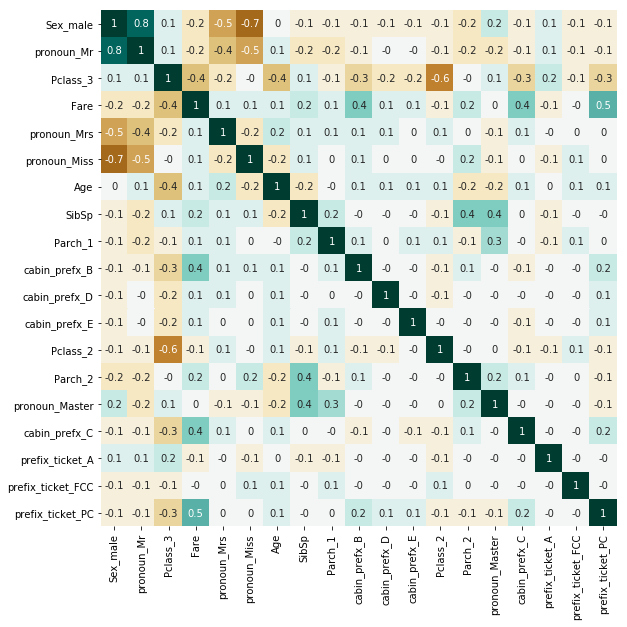

In [23]:
corr = df_quantitative_values.corr().round(1)
plt.figure(figsize=(len(corr)/2, len(corr)/2))

sns.heatmap(corr, cmap='BrBG', vmax=1.0, vmin=-1.0, center=0, annot=True, square=True, cbar=False);

# cross-validation

## hold-out (train e validation)

In [24]:
df_features.head()

PassengerId  Survived   Age  SibSp     Fare  Family_Size  Pclass_2  \
0            1         0  22.0      1   7.2500          2.0         0   
1            2         1  38.0      1  71.2833          2.0         0   
2            3         1  26.0      0   7.9250          1.0         0   
3            4         1  35.0      1  53.1000          2.0         0   
4            5         0  35.0      0   8.0500          2.0         0   

   Pclass_3  Sex_male  Parch_1        ...          prefix_ticket_SOP  \
0         1         1        0        ...                          0   
1         0         0        0        ...                          0   
2         1         0        0        ...                          0   
3         0         0        0        ...                          0   
4         1         1        0        ...                          0   

   prefix_ticket_SOPP  prefix_ticket_SOTONO  prefix_ticket_SOTONOQ  \
0                   0                     0                      0   
1                   0                     0                      0   
2                   0                     0                      0   
3                   0                     0                      0   
4                   0                     0                      0   

   prefix_ticket_SP  prefix_ticket_STONO  prefix_ticket_STONOQ  \
0                 0                    0                     0   
1                 0                    0                     0   
2                 0                    1                     0   
3                 0                    0                     0   
4                 0                    0                     0   

   prefix_ticket_SWPP  prefix_ticket_WC  prefix_ticket_WEP  
0                   0                 0                  0  
1                   0                 0                  0  
2                   0                 0                  0  
3                   0                 0                  0  
4                   0                 0                  0  

[5 rows x 897 columns]

In [25]:
X_train = df_features.iloc[:, 2:]
y_train = df_features.iloc[:, 1]

In [26]:
display(X_train.head())
display(y_train.head())

Age  SibSp     Fare  Family_Size  Pclass_2  Pclass_3  Sex_male  Parch_1  \
0  22.0      1   7.2500          2.0         0         1         1        0   
1  38.0      1  71.2833          2.0         0         0         0        0   
2  26.0      0   7.9250          1.0         0         1         0        0   
3  35.0      1  53.1000          2.0         0         0         0        0   
4  35.0      0   8.0500          2.0         0         1         1        0   

   Parch_2  Parch_3        ...          prefix_ticket_SOP  prefix_ticket_SOPP  \
0        0        0        ...                          0                   0   
1        0        0        ...                          0                   0   
2        0        0        ...                          0                   0   
3        0        0        ...                          0                   0   
4        0        0        ...                          0                   0   

   prefix_ticket_SOTONO  prefix_ticket_SOTONOQ  prefix_ticket_SP  \
0                     0                      0                 0   
1                     0                      0                 0   
2                     0                      0                 0   
3                     0                      0                 0   
4                     0                      0                 0   

   prefix_ticket_STONO  prefix_ticket_STONOQ  prefix_ticket_SWPP  \
0                    0                     0                   0   
1                    0                     0                   0   
2                    1                     0                   0   
3                    0                     0                   0   
4                    0                     0                   0   

   prefix_ticket_WC  prefix_ticket_WEP  
0                 0                  0  
1                 0                  0  
2                 0                  0  
3                 0                  0  
4                 0                  0  

[5 rows x 895 columns]

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## stratified kfold (train e test)

In [27]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True)
kf.get_n_splits(X_train)
print(kf)

StratifiedKFold(n_splits=10, random_state=None, shuffle=True)


### restart measuring variables

In [28]:
x_train_list, y_train_list, x_test_list, y_test_list = list(), list(), list(), list()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = []

# logistic regression

In [29]:
x_train_list, y_train_list, x_test_list, y_test_list = list(), list(), list(), list()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = []

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)

for train_index,test_index in kf.split(X_train,y_train):
    
    X_train_kf, y_train_kf = X_train.iloc[train_index], y_train.iloc[train_index]
    X_test_kf, y_test_kf = X_train.iloc[test_index], y_train.iloc[test_index]

    res = classifier.fit(X_train_kf, y_train_kf)
    y_pred_kf = classifier.predict(X_test_kf)
    
    accuracy_scores.append(accuracy_score(y_test_kf, y_pred_kf))
    precision_scores.append(precision_score(y_test_kf, y_pred_kf))
    recall_scores.append(recall_score(y_test_kf, y_pred_kf))
    f1_scores.append(f1_score(y_test_kf, y_pred_kf))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logis

## validation - mensurando resultados

In [30]:
init_notebook_mode(connected=True)

accuracy_df = pd.DataFrame(accuracy_scores)
f1_df = pd.DataFrame(f1_scores)
recall_df = pd.DataFrame(recall_scores)
precision_df = pd.DataFrame(precision_scores)

trace_acc = go.Scatter(
    x = accuracy_df.index,
    y = accuracy_df[0].values,
    name = 'accuracy'
)
trace_f1 = go.Scatter(
    x = f1_df.index,
    y = f1_df[0].values,
    name = 'f1_score'
)
trace_recall = go.Scatter(
    x = recall_df.index,
    y = recall_df[0].values,
    name = 'recall'
)
trace_precision = go.Scatter(
    x = precision_df.index,
    y = precision_df[0].values,
    name = 'precision'
)

data = [trace_acc, trace_f1, trace_recall, trace_precision]
plotly.offline.iplot(data, filename='logistic_regression_measures.html')

print('Accuracy', np.mean(accuracy_scores))
print('Precision', np.mean(precision_scores))
print('Recall', np.mean(recall_scores))
print('F1-measure', np.mean(f1_scores))

Accuracy 0.8293068323686301
Precision 0.8017664795277275
Recall 0.7427731092436975
F1-measure 0.7679999633373852


# Naive Bayes

In [31]:
x_train_list, y_train_list, x_test_list, y_test_list = list(), list(), list(), list()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = []

from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()

for train_index,test_index in kf.split(X_train,y_train):
    X_train_kf, y_train_kf = X_train.iloc[train_index], y_train.iloc[train_index]
    X_test_kf, y_test_kf = X_train.iloc[test_index], y_train.iloc[test_index]
    
    res = nb.fit(X_train_kf, y_train_kf)
#    importances = list(nb.feature_importances_)
    y_pred_kf = nb.predict(X_test_kf)
    
#    feature_importances.append(importances)
    accuracy_scores.append(accuracy_score(y_test_kf, y_pred_kf))
    precision_scores.append(precision_score(y_test_kf, y_pred_kf))
    recall_scores.append(recall_score(y_test_kf, y_pred_kf))
    f1_scores.append(f1_score(y_test_kf, y_pred_kf))

In [32]:
init_notebook_mode(connected=True)

accuracy_df = pd.DataFrame(accuracy_scores)
f1_df = pd.DataFrame(f1_scores)
recall_df = pd.DataFrame(recall_scores)
precision_df = pd.DataFrame(precision_scores)

trace_acc = go.Scatter(
    x = accuracy_df.index,
    y = accuracy_df[0].values,
    name = 'accuracy'
)
trace_f1 = go.Scatter(
    x = f1_df.index,
    y = f1_df[0].values,
    name = 'f1_score'
)
trace_recall = go.Scatter(
    x = recall_df.index,
    y = recall_df[0].values,
    name = 'recall'
)
trace_precision = go.Scatter(
    x = precision_df.index,
    y = precision_df[0].values,
    name = 'precision'
)

data = [trace_acc, trace_f1, trace_recall, trace_precision]
plotly.offline.iplot(data, filename='random_forest_measures.html')

print('Accuracy', np.mean(accuracy_scores))
print('Precision', np.mean(precision_scores))
print('Recall', np.mean(recall_scores))
print('F1-measure', np.mean(f1_scores))

Accuracy 0.7900439791170129
Precision 0.7408235785267518
Recall 0.6955462184873948
F1-measure 0.7150809868680899


# Random Forest

## kfold (todas as features)

In [33]:
x_train_list, y_train_list, x_test_list, y_test_list = list(), list(), list(), list()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = []

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 2000, max_depth=5)

for train_index,test_index in kf.split(X_train,y_train):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train_kf, y_train_kf = X_train.iloc[train_index], y_train.iloc[train_index]
    X_test_kf, y_test_kf = X_train.iloc[test_index], y_train.iloc[test_index]
    
    res = rf.fit(X_train_kf, y_train_kf)
    importances = list(rf.feature_importances_)
    y_pred_kf = rf.predict(X_test_kf)
    
    feature_importances.append(importances)
    accuracy_scores.append(accuracy_score(y_test_kf, y_pred_kf))
    precision_scores.append(precision_score(y_test_kf, y_pred_kf))
    recall_scores.append(recall_score(y_test_kf, y_pred_kf))
    f1_scores.append(f1_score(y_test_kf, y_pred_kf))

## mensuracao resultado

In [34]:
init_notebook_mode(connected=True)

accuracy_df = pd.DataFrame(accuracy_scores)
f1_df = pd.DataFrame(f1_scores)
recall_df = pd.DataFrame(recall_scores)
precision_df = pd.DataFrame(precision_scores)

trace_acc = go.Scatter(
    x = accuracy_df.index,
    y = accuracy_df[0].values,
    name = 'accuracy'
)
trace_f1 = go.Scatter(
    x = f1_df.index,
    y = f1_df[0].values,
    name = 'f1_score'
)
trace_recall = go.Scatter(
    x = recall_df.index,
    y = recall_df[0].values,
    name = 'recall'
)
trace_precision = go.Scatter(
    x = precision_df.index,
    y = precision_df[0].values,
    name = 'precision'
)

data = [trace_acc, trace_f1, trace_recall, trace_precision]
plotly.offline.iplot(data, filename='random_forest_measures.html')

print('Accuracy', np.mean(accuracy_scores))
print('Precision', np.mean(precision_scores))
print('Recall', np.mean(recall_scores))
print('F1-measure', np.mean(f1_scores))

Accuracy 0.7867875383043923
Precision 0.932650595019016
Recall 0.48235294117647054
F1-measure 0.6294851224289962


## analise feature importance

In [35]:
feature_list = X_train.columns
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Sex_male             Importance: 0.127
Variable: pronoun_Mr           Importance: 0.115
Variable: Fare                 Importance: 0.067
Variable: pronoun_Miss         Importance: 0.067
Variable: Pclass_3             Importance: 0.064
Variable: pronoun_Mrs          Importance: 0.063
Variable: cabin_prefx_D        Importance: 0.026
Variable: cabin_prefx_B        Importance: 0.025
Variable: SibSp                Importance: 0.024
Variable: Age                  Importance: 0.023
Variable: cabin_prefx_E        Importance: 0.021
Variable: Family_Size          Importance: 0.02
Variable: Parch_1              Importance: 0.018
Variable: prefix_ticket_PC     Importance: 0.016
Variable: prefix_ticket_A      Importance: 0.012
Variable: cabin_prefx_C        Importance: 0.009
Variable: Pclass_2             Importance: 0.008
Variable: cabin_prefx_F        Importance: 0.008
Variable: pronoun_Master       Importance: 0.006
Variable: Parch_2              Importance: 0.005
Variable: Family_Name

# Randon Forest *retiradas features nao relevantes*

In [36]:
relevant_features = ["Sex_male","pronoun_Mr","pronoun_Mrs","Fare","Pclass_3","pronoun_Miss","cabin_prefx_B","cabin_prefx_E","SibSp","Age","cabin_prefx_D","Family_Size","prefix_ticket_PC","Parch_1","prefix_ticket_A","cabin_prefx_C","Pclass_2","pronoun_Master"]

In [37]:
x_train_list, y_train_list, x_test_list, y_test_list = list(), list(), list(), list()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = []

X_train_fi = X_train[relevant_features]

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 2000, max_depth=5)

for train_index,test_index in kf.split(X_train_fi,y_train):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    X_train_kf, y_train_kf = X_train_fi.iloc[train_index], y_train.iloc[train_index]
    X_test_kf, y_test_kf = X_train_fi.iloc[test_index], y_train.iloc[test_index]
    
    res = rf.fit(X_train_kf, y_train_kf)
    importances = list(rf.feature_importances_)
    y_pred_kf = rf.predict(X_test_kf)
    
    feature_importances.append(importances)
    accuracy_scores.append(accuracy_score(y_test_kf, y_pred_kf))
    precision_scores.append(precision_score(y_test_kf, y_pred_kf))
    recall_scores.append(recall_score(y_test_kf, y_pred_kf))
    f1_scores.append(f1_score(y_test_kf, y_pred_kf))

## mensuracao resultados

In [38]:
init_notebook_mode(connected=True)

accuracy_df = pd.DataFrame(accuracy_scores)
f1_df = pd.DataFrame(f1_scores)
recall_df = pd.DataFrame(recall_scores)
precision_df = pd.DataFrame(precision_scores)

trace_acc = go.Scatter(
    x = accuracy_df.index,
    y = accuracy_df[0].values,
    name = 'accuracy'
)
trace_f1 = go.Scatter(
    x = f1_df.index,
    y = f1_df[0].values,
    name = 'f1_score'
)
trace_recall = go.Scatter(
    x = recall_df.index,
    y = recall_df[0].values,
    name = 'recall'
)
trace_precision = go.Scatter(
    x = precision_df.index,
    y = precision_df[0].values,
    name = 'precision'
)

data = [trace_acc, trace_f1, trace_recall, trace_precision]
plotly.offline.iplot(data, filename='random_forest_feature_selection_measures.html')

print('Accuracy', np.mean(accuracy_scores))
print('Precision', np.mean(precision_scores))
print('Recall', np.mean(recall_scores))
print('F1-measure', np.mean(f1_scores))

Accuracy 0.829294631710362
Precision 0.8113651237560155
Recall 0.7309243697478991
F1-measure 0.7635229218531594


## Feature importance reanalysed

In [39]:
feature_list = X_train.columns
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Age                  Importance: 0.24
Variable: SibSp                Importance: 0.23
Variable: Family_Size          Importance: 0.11
Variable: Pclass_2             Importance: 0.09
Variable: Fare                 Importance: 0.06
Variable: Pclass_3             Importance: 0.06
Variable: Parch_5              Importance: 0.05
Variable: Parch_3              Importance: 0.04
Variable: Parch_2              Importance: 0.03
Variable: Parch_1              Importance: 0.02
Variable: pronoun_Dr           Importance: 0.02
Variable: Sex_male             Importance: 0.01
Variable: Parch_4              Importance: 0.01
Variable: Parch_6              Importance: 0.01
Variable: Parch_9              Importance: 0.01
Variable: pronoun_Col          Importance: 0.01
Variable: pronoun_Don          Importance: 0.01
Variable: pronoun_Capt         Importance: 0.0


# Gradient Boosting

In [40]:
relevant_features = ["Sex_male","pronoun_Mr","pronoun_Mrs","Fare","Pclass_3","pronoun_Miss","cabin_prefx_B","cabin_prefx_E","SibSp","Age","cabin_prefx_D","Family_Size","prefix_ticket_PC","Parch_1","prefix_ticket_A","cabin_prefx_C","Pclass_2","pronoun_Master"]

In [41]:
x_train_list, y_train_list, x_test_list, y_test_list = list(), list(), list(), list()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = []

X_train_fi = X_train

from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=1000, max_depth=2)

for train_index,test_index in kf.split(X_train_fi,y_train):
    X_train_kf, y_train_kf = X_train_fi.iloc[train_index], y_train.iloc[train_index]
    X_test_kf, y_test_kf = X_train_fi.iloc[test_index], y_train.iloc[test_index]
    
    res = gb.fit(X_train_kf, y_train_kf)
    importances = list(gb.feature_importances_)
    y_pred_kf = gb.predict(X_test_kf)
    
    feature_importances.append(importances)
    accuracy_scores.append(accuracy_score(y_test_kf, y_pred_kf))
    precision_scores.append(precision_score(y_test_kf, y_pred_kf))
    recall_scores.append(recall_score(y_test_kf, y_pred_kf))
    f1_scores.append(f1_score(y_test_kf, y_pred_kf))

In [42]:
gb

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [43]:
init_notebook_mode(connected=True)

accuracy_df = pd.DataFrame(accuracy_scores)
f1_df = pd.DataFrame(f1_scores)
recall_df = pd.DataFrame(recall_scores)
precision_df = pd.DataFrame(precision_scores)

trace_acc = go.Scatter(
    x = accuracy_df.index,
    y = accuracy_df[0].values,
    name = 'accuracy'
)
trace_f1 = go.Scatter(
    x = f1_df.index,
    y = f1_df[0].values,
    name = 'f1_score'
)
trace_recall = go.Scatter(
    x = recall_df.index,
    y = recall_df[0].values,
    name = 'recall'
)
trace_precision = go.Scatter(
    x = precision_df.index,
    y = precision_df[0].values,
    name = 'precision'
)

data = [trace_acc, trace_f1, trace_recall, trace_precision]
plotly.offline.iplot(data, filename='random_forest_feature_selection_measures.html')

print('Accuracy', np.mean(accuracy_scores))
print('Precision', np.mean(precision_scores))
print('Recall', np.mean(recall_scores))
print('F1-measure', np.mean(f1_scores))

Accuracy 0.8372494609011463
Precision 0.8211554246475359
Recall 0.7394957983193277
F1-measure 0.7761448442050003


# XGBoosting

In [ ]:
import numpy as np

from scipy.stats import uniform, randint
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

x_train_list, y_train_list, x_test_list, y_test_list = list(), list(), list(), list()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances = []

X_train_fi = X_train

import xgboost as xgb
xgb = xgb.XGBClassifier(objective="binary:logistic")

for train_index,test_index in kf.split(X_train_fi,y_train):
    X_train_kf, y_train_kf = X_train_fi.iloc[train_index], y_train.iloc[train_index]
    X_test_kf, y_test_kf = X_train_fi.iloc[test_index], y_train.iloc[test_index]
    
    res = gb.fit(X_train_kf, y_train_kf)
    importances = list(gb.feature_importances_)
    y_pred_kf = gb.predict(X_test_kf)
    
    feature_importances.append(importances)
    accuracy_scores.append(accuracy_score(y_test_kf, y_pred_kf))
    precision_scores.append(precision_score(y_test_kf, y_pred_kf))
    recall_scores.append(recall_score(y_test_kf, y_pred_kf))
    f1_scores.append(f1_score(y_test_kf, y_pred_kf))

# Validation base - predict and submit

In [82]:
classifier = gb

X_train_fi = X_train
classifier.fit(X_train_fi, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [91]:
X_valid = df_features_test.iloc[:, 2:]
Ids = df_features_test.iloc[:, 0].reset_index()

In [92]:
X_valid.head()

Age  SibSp     Fare  Family_Size  Pclass_2  Pclass_3  Sex_male  Parch_1  \
891  34.5      0   7.8292          5.0         0         1         1        0   
892  47.0      1   7.0000          1.0         0         1         0        0   
893  62.0      0   9.6875          1.0         1         0         1        0   
894  27.0      0   8.6625          1.0         0         1         1        0   
895  22.0      1  12.2875          2.0         0         1         0        1   

     Parch_2  Parch_3        ...          prefix_ticket_SOP  \
891        0        0        ...                          0   
892        0        0        ...                          0   
893        0        0        ...                          0   
894        0        0        ...                          0   
895        0        0        ...                          0   

     prefix_ticket_SOPP  prefix_ticket_SOTONO  prefix_ticket_SOTONOQ  \
891                   0                     0                      0   
892                   0                     0                      0   
893                   0                     0                      0   
894                   0                     0                      0   
895                   0                     0                      0   

     prefix_ticket_SP  prefix_ticket_STONO  prefix_ticket_STONOQ  \
891                 0                    0                     0   
892                 0                    0                     0   
893                 0                    0                     0   
894                 0                    0                     0   
895                 0                    0                     0   

     prefix_ticket_SWPP  prefix_ticket_WC  prefix_ticket_WEP  
891                   0                 0                  0  
892                   0                 0                  0  
893                   0                 0                  0  
894                   0                 0                  0  
895                   0                 0                  0  

[5 rows x 895 columns]

In [93]:
len(X_valid)

418

In [94]:
y_pred = classifier.predict(X_valid)
y_pred_df = pd.DataFrame(y_pred)

submit_base = pd.DataFrame(pd.concat([Ids["PassengerId"],y_pred_df], axis=1, ignore_index=True))
submit_base.columns = ["PassengerId","Survived"]
submit_base = submit_base.sort_values("PassengerId")
display(submit_base.head())

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

In [95]:
submit_base.to_clipboard()